Attempt of visualizing the way neural networks work

Based on the idea of networks as "rotating" data, through matrix multiplication, and "squashing", through nonlinear activation funcitons.

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, losses
import math

In [123]:
# Generate spiral, non linearly separable classes 

N = 1000 # samples per class
D = 2 # data dimensions
C = 3 # classes
H = 2 # hidden units

X = np.zeros([N * C, D]) # data matrix / tensor
y = np.zeros(N * C, dtype='long') # class labels

for c in range(C):
    index = 0
    # generate spiral data for each class
    t = np.linspace(0, 1, N) # parameter values

    inner_var = np.linspace(
        (2 * math.pi / C) * (c),
        (2 * math.pi / C) * (2 + c),
        N
    ) + tf.random.normal((N,)) * 0.2

    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * np.array([math.sin(inner_var[index]), math.cos(inner_var[index])], dtype='float')
        y[ix] = c
        index += 1


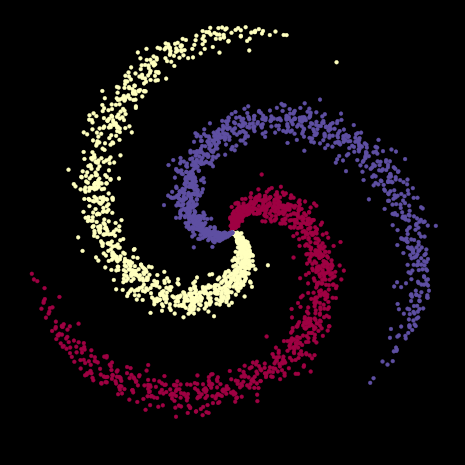

In [124]:
# Set plot colors
figsize = (10, 10)
dpi = 60

plt.style.use(['dark_background', 'bmh'])
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')
plt.rc('figure', figsize=figsize, dpi=dpi)

def plot_data(X, y):
    # fig, ax = plt.subplots(figsize=(17, 17), dpi=30)
    plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)))
    plt.axis('off')

plot_data(X, y)

[array([[-0.80939406, -0.6248167 ],
       [-0.12585986, -0.6858898 ]], dtype=float32), array([0., 0.], dtype=float32)]
det(W) = 0.47651577


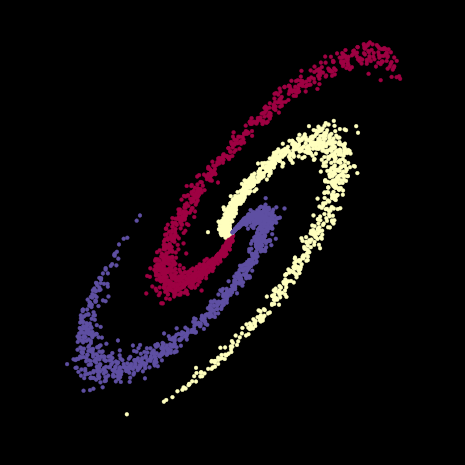

In [125]:
# simple linear dense layer
# applies an affine transformation with
# weight matrix and biases

model = keras.Sequential([
    keras.Input(shape=(D,)),
    layers.Dense(H, activation='linear'),
])

for layer in model.layers:
    w = layer.get_weights()
    print(w)
    print('det(W) =', np.linalg.det(w[0]))

plot_data(model(X), y)

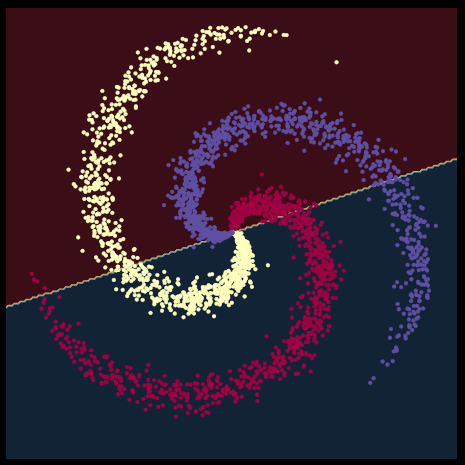

In [126]:
def plot_model(model, x, y):
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    # reshape(-1): into 1-d array, -1 means numpy figures out shape
    data_stack = np.vstack((xx.reshape(-1), yy.reshape(-1))).T
    data = tf.convert_to_tensor(data_stack)
    Z = model(data)
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(x, y)
    
plot_model(model, X, y)

[array([[-1.2224224 ,  0.9245955 ],
       [ 0.96922696,  0.527972  ]], dtype=float32), array([0., 0.], dtype=float32)]
det(W) = -1.5415477


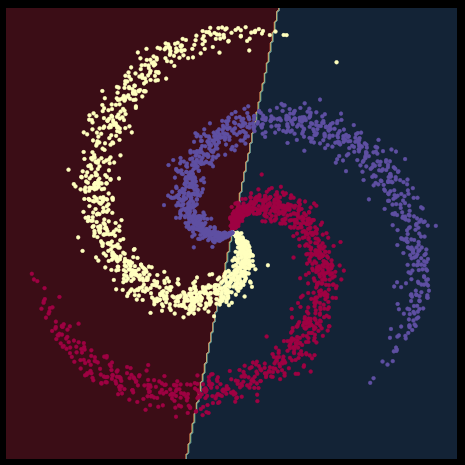

In [127]:
# with nonlinear activation function

model = keras.Sequential([
    keras.Input(shape=(D,)),
    layers.Dense(H, activation='tanh'),
])

for layer in model.layers:
    w = layer.get_weights()
    print(w)
    print('det(W) =', np.linalg.det(w[0]))

plot_model(model, X, y)

In [134]:
# How does it look for a trained model?

model = keras.Sequential([
    keras.Input(shape=(D,)),
    layers.Dense(100, activation='relu'),
    layers.Dense(D, activation='relu')
    layers.Dense(C, activation='linear')
])


In [129]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.batch(32)

# list(dataset.as_numpy_iterator())

In [130]:
# Define loss & gradient step functions

# Sparse uses regular class indices instead of one hot
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y):
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_)

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

features, labels = next(iter(dataset))
print("loss: {}".format(loss(model, features, labels)))


loss: 1.0969321727752686


In [131]:
# Look at loss before & after single gradient step

loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial loss: {}".format(
    optimizer.iterations.numpy(), loss_value.numpy()
))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {}, Loss: {}".format(
    optimizer.iterations.numpy(), loss(model, features, labels).numpy()
))

Step: 0, Initial loss: 1.0969321727752686
Step: 1, Loss: 1.0901048183441162


In [136]:
n_epochs = 300

train_loss_results = []
train_accuracy_results = []

for epoch in range(n_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # training loop
    for feats, labels in dataset:
        loss_value, grads = grad(model, feats, labels)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Record loss & acc for printing
        epoch_loss_avg.update_state(loss_value)
        epoch_accuracy.update_state(labels, model(feats))
     
    # Record loss & acc for plotting
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())


    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(
        epoch, epoch_loss_avg.result(), epoch_accuracy.result()))

Epoch 000: Loss: 0.486, Accuracy: 78.133%
Epoch 001: Loss: 0.483, Accuracy: 78.333%
Epoch 002: Loss: 0.481, Accuracy: 78.500%
Epoch 003: Loss: 0.478, Accuracy: 78.567%
Epoch 004: Loss: 0.475, Accuracy: 78.700%
Epoch 005: Loss: 0.472, Accuracy: 78.767%
Epoch 006: Loss: 0.469, Accuracy: 78.867%
Epoch 007: Loss: 0.466, Accuracy: 78.967%
Epoch 008: Loss: 0.464, Accuracy: 79.367%
Epoch 009: Loss: 0.461, Accuracy: 79.467%
Epoch 010: Loss: 0.458, Accuracy: 79.700%
Epoch 011: Loss: 0.455, Accuracy: 80.000%
Epoch 012: Loss: 0.453, Accuracy: 80.133%
Epoch 013: Loss: 0.450, Accuracy: 80.333%
Epoch 014: Loss: 0.448, Accuracy: 80.500%
Epoch 015: Loss: 0.445, Accuracy: 80.500%
Epoch 016: Loss: 0.442, Accuracy: 80.667%
Epoch 017: Loss: 0.440, Accuracy: 80.833%
Epoch 018: Loss: 0.437, Accuracy: 80.867%
Epoch 019: Loss: 0.435, Accuracy: 81.033%
Epoch 020: Loss: 0.432, Accuracy: 81.100%
Epoch 021: Loss: 0.430, Accuracy: 81.167%
Epoch 022: Loss: 0.428, Accuracy: 81.300%
Epoch 023: Loss: 0.425, Accuracy: 

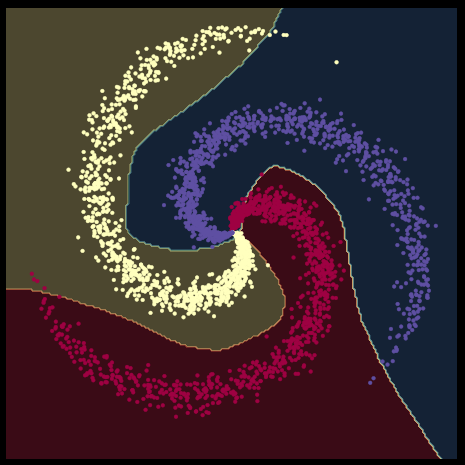

In [137]:
plot_model(model, X,  y)